# Spectrogram setup in Python

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import NMF

In [79]:
def get_all_pat_chn_trials(patient_num, session_idx, tot_num_channels):
    """Get all trials for each channel for a given category"""
    
    patient_ref = f"P{patient_num:02}"
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") for channel_idx in range(tot_num_channels)]

    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop=0.5, sample_rows=False):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96, log_Sxx=False):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def specgram_trials(arr_all_trials, trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

In [81]:
def specgram_wrapper(arr_all_trials, tot_num_channels, trials_samp_idx=None, 
                     filter_row_idx=None, log_Sxx=False):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx], 
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(tot_num_channels)]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

In [82]:
def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

In [83]:
def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

In [74]:
def plotW(W, log=True):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.ylim(-2, W_plt.max())
        plt.xlim(0, W_plt.shape[0])
        plt.ylabel('Component %d' % n)

### Plot the rows of H i.e. the temporal activations

In [75]:
def plotH(H, log=False):
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H.shape[0]):
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(H[n])
        plt.ylim(0, H.max())
        plt.xlim(0, H.shape[1])
        plt.ylabel('Component %d' % n)

# 85 Channels - P35, Faces, Session 1

In [86]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 35
tot_num_channels = 85
session_idx = 1
core_cat = "Faces"
samp_prop = 0.2
max_iter = 400

In [90]:
# Get all the channels and trials (DONE)
all_patient_trials = get_all_pat_chn_trials(patient_num = patient_num, session_idx = session_idx, 
                                            tot_num_channels = tot_num_channels)

#trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_prop)
#comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, trials_samp_idx=trials_samp_idx, tot_num_channels = tot_num_channels, filter_row_idx=None)

# Fit the spectrograms and hstack the histograms
comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, trials_samp_idx=None, 
                                               tot_num_channels = tot_num_channels, filter_row_idx=None, log_Sxx=False)

# randomly sample across time
time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, samp_prop=0.2, sample_rows=False)
print(comb_all_channels_specgrams.shape)
#print(len(time_samp_idx))
#comb_specgram1 = comb_all_channels_specgrams[:, time_samp_idx]
comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, time_samp_idx=time_samp_idx)
print(comb_specgram_time_sample.shape)
#print(comb_specgram1.shape)

(65, 303365)
(65, 60673)


In [91]:
# perform NMF
V1, W1, H1 = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, n_components=8, 
                         init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu',max_iter=max_iter)

V: (65, 60673)
W: (65, 8)
H: (8, 60673)


- Ask Max about log values of spectrograms producing negative values (when in range 0-1), so can't directly do NMF

/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


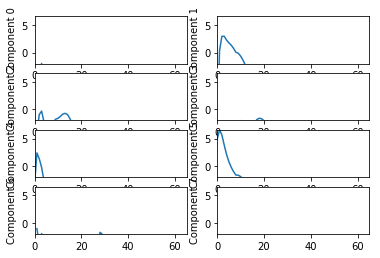

In [68]:
plotW(W = W1, log=True)

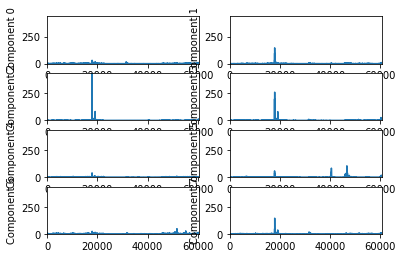

In [69]:
plotH(H = H1, log=False)